<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/Self_Adaptive_PINNS_Buckley_Leverett.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
pip install --upgrade pyDOE

In [28]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import Input, Dense, InputLayer
from time import time
from keras.optimizers import Adam
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pyDOE import lhs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize

In [29]:
keras.backend.set_floatx('float32')
tf.random.set_seed(1234)

In [30]:
#Definindo as condições de contorno e inicial
def inicial(x):
  return tf.constant(0., shape = (x.shape[0], 1))

def contorno(t, x):
  n = x.shape[0]
  return tf.where(tf.equal(x, 0), tf.ones((n, 1)), tf.zeros((n, 1)))

#função do fluxo fracionario de água, em função da saturação de agua e da mobilidade
def fw(u,M):
  return (u**2)/((u**2) + ((1-u)**2)/M)

#Definindo os pontos X
N_0 = 300 #100 pontos para condição inicial
N_b = 300 #100 pontos para condição de contorno
N_r = 20000 #Pontos para a edp

#Pontos do domínio
tmin = 0. ; tmax = 1.
xmin = 0.; xmax = 1.

#Ponto inferior e superior, respectivamente
lb = tf.constant([tmin, xmin]); ub = tf.constant([tmax, xmax])

In [31]:
#Obtendo pontos para a condição inicial
t0 = tf.zeros((N_0,1))*lb[0]
x0 = tf.random.uniform((N_0,1), lb[1], ub[1]) #Colocando os valores de x0 em ordem aleatoria, indo de -1 a 1
x0 = tf.concat([t0, x0], 1) #Criando uma matriz com os valores de tempo = 0 e de x0

#Valores de u para a condição inicial
u_ini = inicial(x0[:,1:2])

#Repetindo o processo, mas para a condição de contorno
tb = tf.random.uniform((N_b,1), lb[0], ub[0])
xb = lb[1] + (ub[1] - lb[1]) * keras.backend.random_bernoulli((N_b,1), 0.5)
#xb = tf.zeros((N_b,1))*lb[1]
xb = tf.concat([tb, xb], 1)

#Valores na condição de contorno
u_cont = contorno(xb[:,0:1], xb[:,1:2])

#Repetindo o processo, mas agora é para obter os pontos da EDP
tr = tf.random.uniform((N_r,1), lb[0], ub[0])
xr = tf.random.uniform((N_r,1), lb[1], ub[1])
xr = tf.concat([tr, xr], 1)

#Fazendo uma lista, para uso posterior
X_cond = [x0, xb]
u_cond = [u_ini, u_cont]

#Realizando plotagem dos pontos que são usados para condição de contorno, inicial e para edp

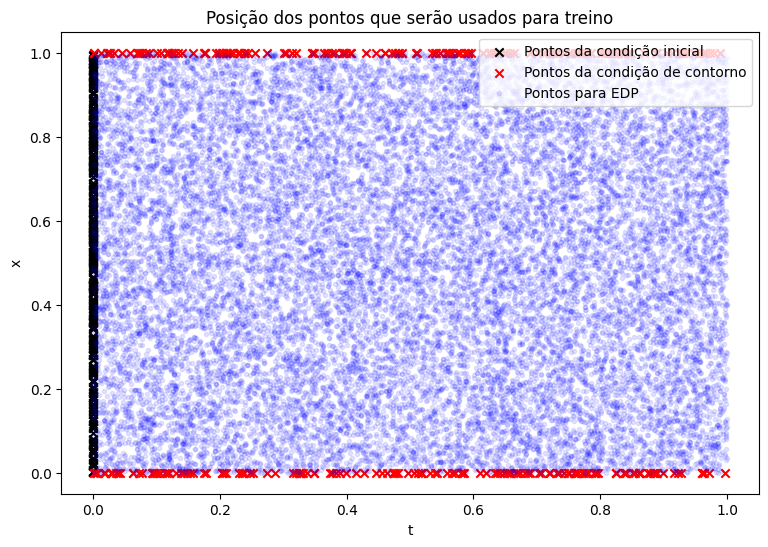

In [32]:
plt.figure(figsize=(9,6))
plt.scatter(x0[:,0:1],x0[:,1:2], c='black', marker ='x')
plt.scatter(xb[:,0:1],xb[:,1:2], c='red', marker ='x')
plt.scatter(xr[:,0:1], xr[:,1:2], c='blue', marker = '.', alpha = 0.1)
plt.xlabel('t'); plt.ylabel('x')
plt.title('Posição dos pontos que serão usados para treino')
plt.legend(['Pontos da condição inicial', 'Pontos da condição de contorno', 'Pontos para EDP'])
plt.show()

In [33]:
peso_pini = tf.Variable(tf.random.uniform([N_0, 1]))
peso_pedp = tf.Variable(tf.reshape(tf.repeat(100.0, N_r),(N_r, -1)))
peso_pcont = tf.Variable(tf.random.uniform([N_b,1]))

In [34]:
def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, state, maxIter = 100, learningRate = 1, do_verbose = True):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  global final_loss, times

  maxEval = maxIter*1.25
  tolFun = 1e-5
  tolX = 1e-9
  nCorrection = 50
  isverbose = False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None

  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time()

    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)

      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])


      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]

      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f

    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate



    x += t*d

    if nIter != maxIter:
    # re-evaluate function only if not in last iteration
    # the reason we do this: in a stochastic setting,
    # no use to re-evaluate that function here
      f, g = opfunc(x)

    lsFuncEval = 1
    f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      print('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      print('optimality condition below tolFun')
      break

    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      print('step size below tolX')
      break

    if tf.abs(f,f_old) < tolX:
      # function value changing less than tolX
      print('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      if nIter % 10 == 0:
        print("Step %3d loss %6.5f "%(nIter, f.numpy()))


    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)


In [35]:
camadas = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

sizes_w = []
sizes_b = []
for i, width in enumerate(camadas):
    if i != 1:
        sizes_w.append(int(width * camadas[1]))
        sizes_b.append(int(width if i != 0 else camadas[1]))

def set_weights(modelo, w, sizes_w, sizes_b):
        for i, layer in enumerate(modelo.layers[0:]):
            start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
            end_weights = sum(sizes_w[:i+1]) + sum(sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(sizes_w[i] / sizes_b[i])
            weights = tf.reshape(weights, [w_div, sizes_b[i]])
            biases = w[end_weights:end_weights + sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)



def get_weights(modelo):
        w = []
        for layer in modelo.layers[0:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)

        w = tf.convert_to_tensor(w)
        return w


def modelopinn(camadas):
    modelo = Sequential()
    #modelo.add(InputLayer(input_shape=(camadas[0],)))
    modelo.add(Input(2,))
    for width in camadas[1:-1]:
        modelo.add(Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"))
    modelo.add(Dense(
            camadas[-1], activation=None,
            kernel_initializer="glorot_normal"))
    return modelo

modelo = modelopinn(camadas)
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 20)                60        
                                                                 
 dense_19 (Dense)            (None, 20)                420       
                                                                 
 dense_20 (Dense)            (None, 20)                420       
                                                                 
 dense_21 (Dense)            (None, 20)                420       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 20)               

In [36]:
@tf.function
def f_model(modelo, X_r):
  with tf.GradientTape(persistent=True) as tape:
    t, x = X_r[:, 0:1], X_r[:,1:2]
    tape.watch(t)
    tape.watch(x)
    u = modelo(tf.concat([t, x], 1))
    tape.watch(u)

    #k_rw = ((u - Swi)/(1-Swi-Swo))**2
    #k_ro = ((1- u - Swi)/(1-Swi-Swo))**2
    #f = (k_rw/u_w)/((k_rw/u_w) + (k_ro/u_o))
    #f = 1/(1+(k_ro/u_w)*(u_o/k_rw))
    f = fw(u, 2)
    f_u = tape.gradient(f,u)
    f_x = tape.gradient(f,x)

    ux = tape.gradient(u, x)
    ut = tape.gradient(u, t)
    uxx = tape.gradient(ux, x)

  del tape
  #return ut + f_u*ux
  return ut + f_x


def MSE(modelo, xr, x0, u_ini, xb, u_cont, peso_pedp, peso_pini, peso_pcont):
    #Erro edp
    r = f_model(modelo, xr)
    mse_edp = tf.reduce_mean(tf.square(peso_pedp*r))
    print(mse_edp)

    loss = mse_edp

    #Erro da rede neural pra condição inicial
    u_pred1 = modelo(x0)
    #u_pred = modelo(tf.concat([x0[:, 0:1][i], x0[:, 1:2][i]], 1))
    mse_0 = tf.reduce_mean(tf.square(peso_pini*(u_ini[i] - u_pred1)))
    loss += mse_0

    #Erro da rede neural pra condição de contorno
    u_pred = modelo(xb)
    mse_cont = tf.reduce_mean(tf.square(peso_pcont*(u_cont[i] - u_pred)))
    loss += mse_cont

    return loss, mse_edp, mse_0, mse_cont

@tf.function
def grad(modelo, xr, x0, u_ini, x_cont, u_cont, peso_pedp, peso_pini, peso_pcont):
    with tf.GradientTape(persistent=True) as tape:
        #tape.watch(peso_pedp)
        #tape.watch(peso_pini)
        #tape.watch(peso_pcont)
        loss_value, mse_edp, mse_0, mse_cont = MSE(modelo, xr, x0, u_ini, x_cont, u_cont, peso_pedp, peso_pini, peso_pcont)
        grads = tape.gradient(loss_value, modelo.trainable_variables)
        print(grads)
        grads_edp = tape.gradient(loss_value, peso_pedp)
        grads_ini = tape.gradient(loss_value, peso_pini)
        grads_cont = tape.gradient(loss_value, peso_pcont)

    return loss_value, mse_edp, mse_0, mse_cont, grads, grads_edp, grads_ini, grads_cont

In [37]:
def treino(model, xr, x0, u_ini, x_cont, u_cont, peso_pedp, peso_pini, peso_pcont, tf_iter, newton_iter):
    start_time = time()
    otimizador = Adam(learning_rate = 0.001, beta_1=.90)
    otimizador_edp = Adam(learning_rate = 0.001, beta_1=.90)
    otimizador_ini = Adam(learning_rate = 0.001, beta_1=.90)
    otimizador_cont = Adam(learning_rate = 0.001, beta_1=.90)
    print("Treino com o Adam")

    for epoch in range(tf_iter):
      loss_value, mse_f, mse_0, mse_cont, grads, grads_edp, grads_ini, grads_cont = grad(model, xr, x0, u_ini, x_cont, u_cont, peso_pedp, peso_pini, peso_pcont)

      otimizador.apply_gradients(zip(grads, modelo.trainable_variables))
      otimizador_edp.apply_gradients(zip([-grads_edp], [peso_pedp]))
      otimizador_ini.apply_gradients(zip([-grads_ini], [peso_pini]))
      otimizador_cont.apply_gradients(zip([-grads_cont], [peso_pcont]))


      if epoch % 100 == 0:
          elapsed = time() - start_time
          print('It: %d, Time: %.2f' % (epoch, elapsed))
          tf.print(f"mse_edp = {mse_f} \ mse_0 = {mse_0} \ mse_cont = {mse_cont} \ total loss = {loss_value}")
          start_time = time()



    print("Treino com o L-BFGS-B")

    loss_and_flat_grad = get_loss_and_flat_grad(modelo, xr, x0, u_ini, x_cont, u_cont, peso_pedp, peso_pini, peso_pcont)

    lbfgs(loss_and_flat_grad,
      get_weights(modelo),
      Struct(), maxIter=newton_iter, learningRate=0.8)


#https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad(modelo, xr, x0, u_ini, xb, u_cont, peso_pedp, peso_pini, peso_pcont):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(modelo, w, sizes_w, sizes_b)
            loss_value, mse_edp, mse_0, mse_cont = MSE(modelo, xr, x0, u_ini, xb, u_cont, peso_pedp, peso_pini, peso_pcont)
        grad = tape.gradient(loss_value, modelo.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        #print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad

treino(modelo, xr, x0, u_ini, xb, u_cont, peso_pedp, peso_pini, peso_pcont, tf_iter = 5000, newton_iter = 3900)


Treino com o Adam
Tensor("Mean:0", shape=(), dtype=float32)
[<tf.Tensor 'AddN:0' shape=(2, 20) dtype=float32>, <tf.Tensor 'AddN_1:0' shape=(20,) dtype=float32>, <tf.Tensor 'AddN_2:0' shape=(20, 20) dtype=float32>, <tf.Tensor 'AddN_3:0' shape=(20,) dtype=float32>, <tf.Tensor 'AddN_4:0' shape=(20, 20) dtype=float32>, <tf.Tensor 'AddN_5:0' shape=(20,) dtype=float32>, <tf.Tensor 'AddN_6:0' shape=(20, 20) dtype=float32>, <tf.Tensor 'AddN_7:0' shape=(20,) dtype=float32>, <tf.Tensor 'AddN_8:0' shape=(20, 20) dtype=float32>, <tf.Tensor 'AddN_9:0' shape=(20,) dtype=float32>, <tf.Tensor 'AddN_10:0' shape=(20, 20) dtype=float32>, <tf.Tensor 'AddN_11:0' shape=(20,) dtype=float32>, <tf.Tensor 'AddN_12:0' shape=(20, 20) dtype=float32>, <tf.Tensor 'AddN_13:0' shape=(20,) dtype=float32>, <tf.Tensor 'AddN_14:0' shape=(20, 20) dtype=float32>, <tf.Tensor 'AddN_15:0' shape=(20,) dtype=float32>, <tf.Tensor 'AddN_16:0' shape=(20, 1) dtype=float32>, <tf.Tensor 'AddN_17:0' shape=(1,) dtype=float32>]
It: 0, Ti

In [38]:
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

#Realizando predição
upred = modelo(Xgrid)

U = upred.numpy().reshape(N+1,N+1)

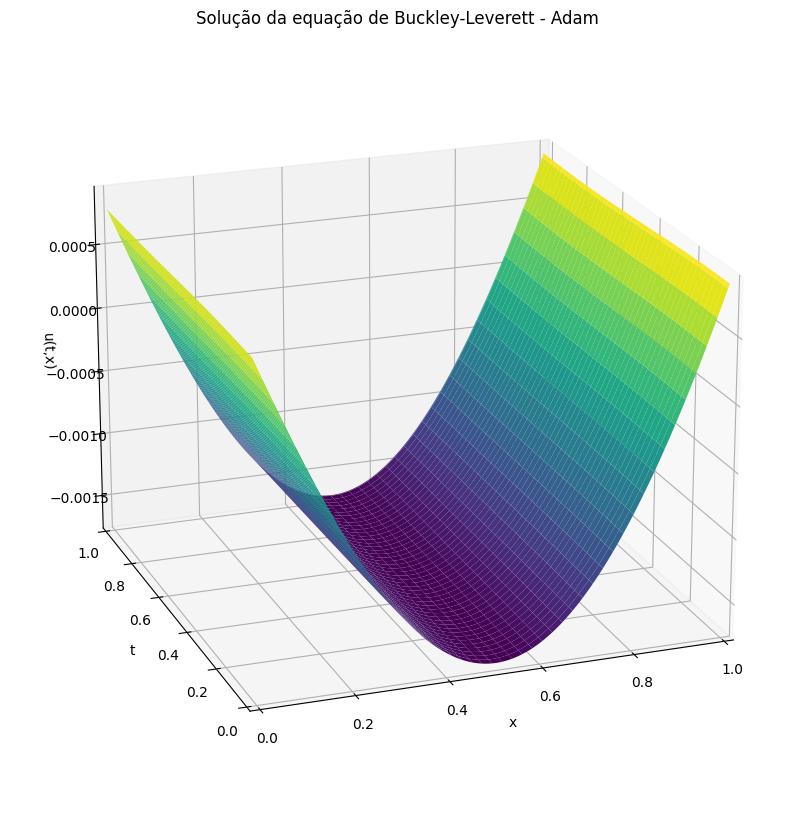

In [39]:
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, cmap='viridis');
ax.view_init(20,70)
ax.set_xlim(1,0)
ax.set_ylim(1,0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(t,x)')
ax.set_title('Solução da equação de Buckley-Leverett - Adam');
plt.show()